# Sentence Embeddings Analysis - Tutorial

## What are Embeddings?

**Embeddings** are numerical representations of text that capture semantic meaning. Instead of treating words or sentences as discrete symbols, embeddings represent them as vectors (lists of numbers) in a high-dimensional space.

### Key Concepts:

1. **Vector Representation**: Each headline becomes a list of numbers (e.g., 384 dimensions)
2. **Semantic Similarity**: Similar meanings → similar vectors → high cosine similarity
3. **Distance Metric**: Cosine similarity measures how similar two vectors are

### Why Use Embeddings?

- Capture semantic meaning (not just word overlap)
- Enable semantic search
- Support clustering and classification
- Work with any text length

In this notebook, we use **sentence-transformers** (based on Hugging Face) to generate embeddings for 10,000 news headlines.

## 1. Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json
import os

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

print("All imports successful!")


All imports successful!


## 2. Load Dataset

In [2]:
# Load extended headlines dataset
df = pd.read_csv('../extended/news_headlines_extended.csv')

print(f"Dataset loaded!")
print(f"Total headlines: {len(df):,}")
print(f"\nCategory distribution:")
print(df['category'].value_counts())
print(f"\nFirst 5 headlines:")
df[['headline', 'category']].head()

Dataset loaded!
Total headlines: 10,000

Category distribution:
category
Technology       2500
Sports           2500
Politics         2500
Entertainment    2500
Name: count, dtype: int64

First 5 headlines:


,headline,category
0,cloud computing chips face global supply shortage,Technology
1,Hill leads Knights to fifth straight victory,Sports
2,Local referendum on housing scheduled for Febr...,Politics
3,Hill retires after 2 years with Panthers,Sports
4,Allen retires after 2 years with Phoenix,Sports


## 3. Load or Generate Embeddings

In [3]:
# Check if embeddings already exist
embeddings_exist = os.path.exists('data/headlines_embeddings.npy')

if embeddings_exist:
    print("Loading existing embeddings...")
    embeddings = np.load('data/headlines_embeddings.npy')
    
    with open('data/embeddings_metadata.json', 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    print(f"Loaded {len(embeddings):,} embeddings")
    print(f"Shape: {embeddings.shape}")
    print(f"Model: {metadata['model_name']}")
else:
    print("Embeddings not found. Generating...")
    print("This will take 1-2 minutes...\n")
    
    # Load model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    # Generate embeddings
    headlines = df['headline'].tolist()
    embeddings = model.encode(headlines, 
                             batch_size=32, 
                             show_progress_bar=True,
                             convert_to_numpy=True)
    
    # Save for future use
    os.makedirs('data', exist_ok=True)
    np.save('data/headlines_embeddings.npy', embeddings)
    
    print(f"\nGenerated and saved {len(embeddings):,} embeddings")
    print(f"Shape: {embeddings.shape}")

Embeddings not found. Generating...
This will take 1-2 minutes...



Batches:   0%|          | 0/313 [00:00<?, ?it/s]


Generated and saved 10,000 embeddings
Shape: (10000, 384)


## 4. Understanding Embeddings

Each headline is now represented as a vector of 384 numbers. Let's explore what this means.

In [4]:
print("Embedding Properties:")
print("=" * 60)
print(f"Number of embeddings: {embeddings.shape[0]:,}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Total parameters: {embeddings.shape[0] * embeddings.shape[1]:,}")
print(f"Memory size: {embeddings.nbytes / (1024**2):.2f} MB")

print("\nFirst embedding (first 10 dimensions):")
print(embeddings[0][:10])
print(f"\nCorresponding headline: {df['headline'].iloc[0]}")

# Calculate norms
norms = np.linalg.norm(embeddings, axis=1)
print(f"\nEmbedding norms:")
print(f"  Mean: {norms.mean():.4f}")
print(f"  Std:  {norms.std():.4f}")
print(f"  Min:  {norms.min():.4f}")
print(f"  Max:  {norms.max():.4f}")

Embedding Properties:
Number of embeddings: 10,000
Embedding dimension: 384
Total parameters: 3,840,000
Memory size: 14.65 MB

First embedding (first 10 dimensions):
[-0.00843354  0.0024562   0.05569877 -0.02105165  0.04682003 -0.02033281
 -0.08736786 -0.0427178  -0.00302898  0.04449807]

Corresponding headline: cloud computing chips face global supply shortage

Embedding norms:
  Mean: 1.0000
  Std:  0.0000
  Min:  1.0000
  Max:  1.0000


## 5. Cosine Similarity

**Cosine similarity** measures the cosine of the angle between two vectors. It ranges from -1 to 1:
- 1: Identical direction (very similar)
- 0: Orthogonal (unrelated)
- -1: Opposite direction (very dissimilar)

Formula: `similarity = (A · B) / (||A|| × ||B||)`

In [5]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Compare a few headlines
indices = [0, 1, 10, 100]

print("Sample Headlines:")
for i in indices:
    print(f"  {i}: [{df['category'].iloc[i]}] {df['headline'].iloc[i]}")

print("\nPairwise Cosine Similarities:")
print("\n      ", end="")
for i in indices:
    print(f"{i:6d} ", end="")
print()

for i in indices:
    print(f"{i:4d}: ", end="")
    for j in indices:
        sim = cosine_similarity(embeddings[i], embeddings[j])
        print(f"{sim:6.3f} ", end="")
    print()

Sample Headlines:
  0: [Technology] cloud computing chips face global supply shortage
  1: [Sports] Hill leads Knights to fifth straight victory
  10: [Sports] Brown injured in Titans game against Rockets
  100: [Politics] Budget committee approves 5 million for education

Pairwise Cosine Similarities:

           0      1     10    100 
   0:  1.000 -0.010  0.117 -0.018 
   1: -0.010  1.000  0.124 -0.014 
  10:  0.117  0.124  1.000 -0.029 
 100: -0.018 -0.014 -0.029  1.000 


## 6. Semantic Search Example

Semantic search finds headlines similar in meaning, not just word overlap.

In [6]:
def semantic_search(query, top_k=5):
    if 'model' not in globals():
        global model
        model = SentenceTransformer('all-MiniLM-L6-v2')
    
    query_embedding = model.encode(query, convert_to_numpy=True)
    
    similarities = []
    for i, emb in enumerate(embeddings):
        sim = cosine_similarity(query_embedding, emb)
        similarities.append((i, sim))
    
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    return similarities[:top_k]

# Try some queries
queries = [
    "president announces new policy",
    "team wins championship",
    "new technology innovation"
]

for query in queries:
    print(f"\nQuery: '{query}'")
    print("-" * 70)
    
    results = semantic_search(query, top_k=3)
    
    for rank, (idx, sim) in enumerate(results, 1):
        cat = df['category'].iloc[idx]
        headline = df['headline'].iloc[idx]
        print(f"{rank}. [Score: {sim:.4f}] [{cat}] {headline}")


Query: 'president announces new policy'
----------------------------------------------------------------------
1. [Score: 0.4441] [Politics] President Kim announces new energy initiative
2. [Score: 0.4289] [Politics] President Smith announces new healthcare initiative
3. [Score: 0.4234] [Politics] Election results show shift toward Reform policies

Query: 'team wins championship'
----------------------------------------------------------------------
1. [Score: 0.6021] [Sports] Warriors clinches division title with dramatic win
2. [Score: 0.6021] [Sports] Warriors clinches division title with dramatic win
3. [Score: 0.6021] [Sports] Warriors clinches division title with dramatic win

Query: 'new technology innovation'
----------------------------------------------------------------------
1. [Score: 0.6023] [Technology] TechCorp announces artificial intelligence breakthrough
2. [Score: 0.5443] [Technology] Developers create innovative communication using artificial intelligence
3. [Scor

## 7. Dimensionality Reduction with PCA

**PCA (Principal Component Analysis)** reduces 384 dimensions to 2 dimensions for visualization.

It finds the directions of maximum variance in the data.

Applying PCA...

Explained variance ratio:
  PC1: 0.0551
  PC2: 0.0432
  Total: 0.0984


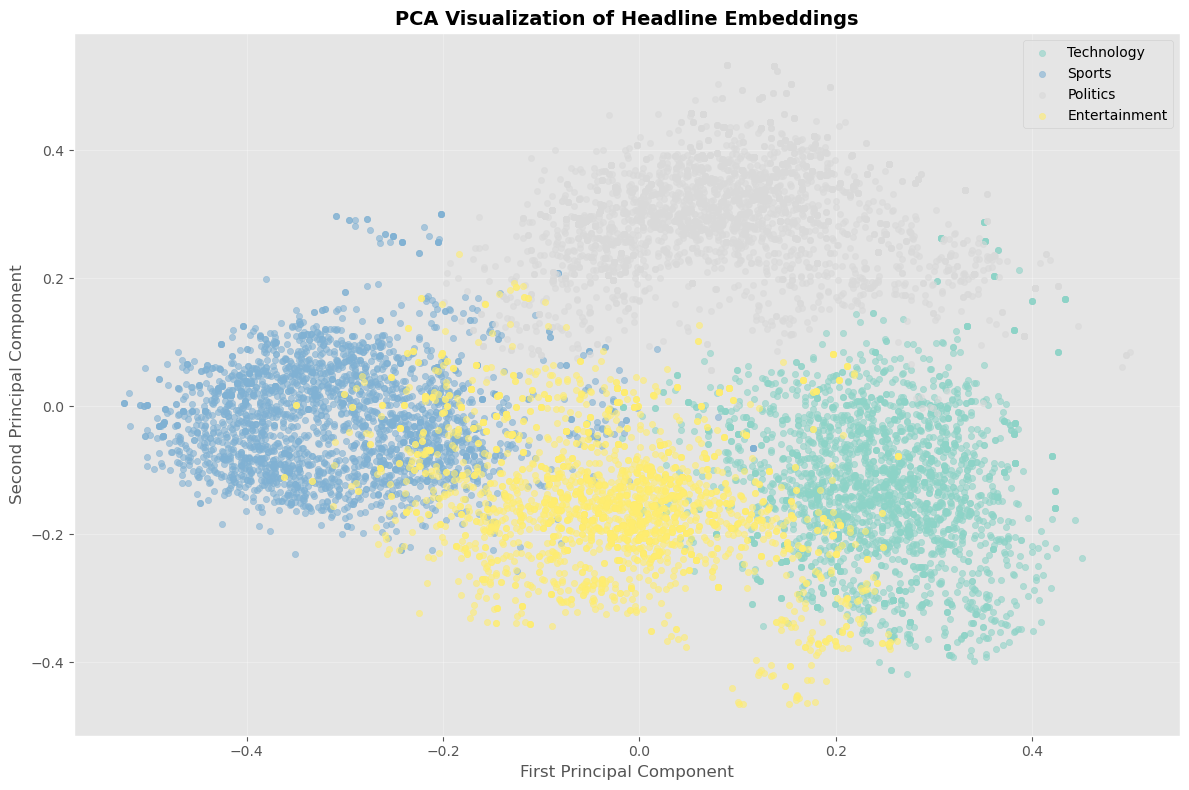


Plot saved to: visualizations/pca_visualization.png


In [7]:
print("Applying PCA...")
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

print(f"\nExplained variance ratio:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Total: {pca.explained_variance_ratio_.sum():.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(12, 8))

categories = df['category'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))

for i, category in enumerate(categories):
    mask = df['category'] == category
    ax.scatter(embeddings_2d_pca[mask, 0], 
              embeddings_2d_pca[mask, 1],
              c=[colors[i]], 
              label=category,
              alpha=0.6,
              s=20)

ax.set_xlabel('First Principal Component', fontsize=12)
ax.set_ylabel('Second Principal Component', fontsize=12)
ax.set_title('PCA Visualization of Headline Embeddings', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/pca_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: visualizations/pca_visualization.png")

## 8. Dimensionality Reduction with t-SNE

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is better at preserving local structure.

It's non-linear and often reveals clusters better than PCA.

Applying t-SNE...
This may take 2-3 minutes...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...


C:\Users\OsterriederJRO\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 0.296s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.461516
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.225334
[t-SNE] KL divergence after 1000 iterations: 0.941871

t-SNE complete! Reduced 2000 embeddings from 384D to 2D


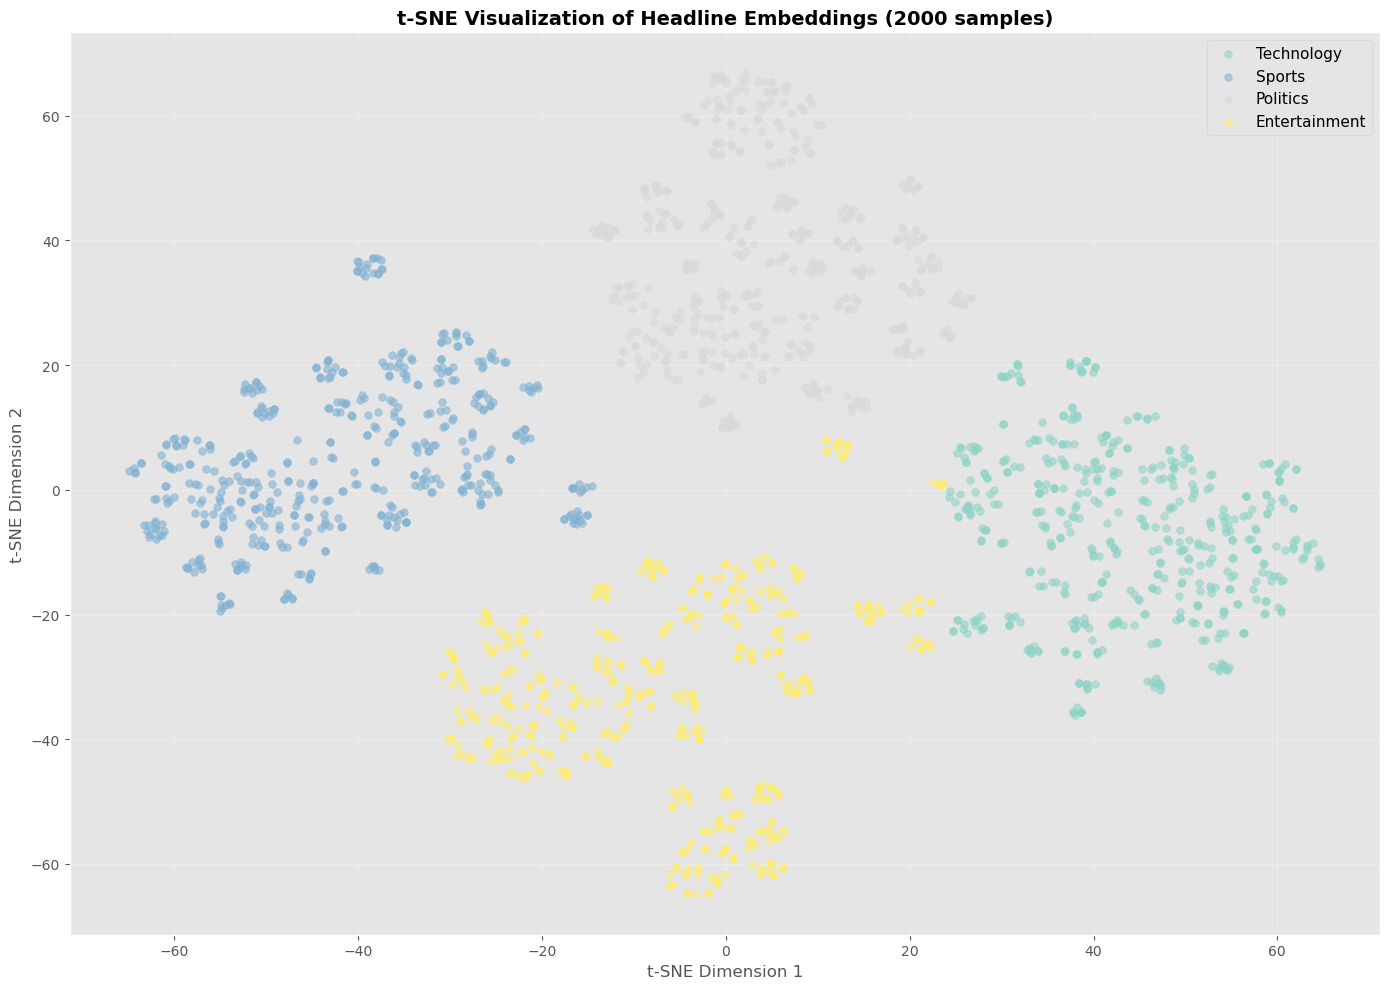


Plot saved to: visualizations/tsne_visualization.png


In [8]:
print("Applying t-SNE...")
print("This may take 2-3 minutes...\n")

# Use a subset for faster computation in demo
n_samples = 2000
sample_indices = np.random.choice(len(embeddings), n_samples, replace=False)

tsne = TSNE(n_components=2, 
            random_state=42, 
            perplexity=30,
            n_iter=1000,
            verbose=1)

embeddings_2d_tsne = tsne.fit_transform(embeddings[sample_indices])

print(f"\nt-SNE complete! Reduced {n_samples} embeddings from 384D to 2D")

# Visualize
fig, ax = plt.subplots(figsize=(14, 10))

df_sample = df.iloc[sample_indices]

for i, category in enumerate(categories):
    mask = df_sample['category'] == category
    ax.scatter(embeddings_2d_tsne[mask, 0], 
              embeddings_2d_tsne[mask, 1],
              c=[colors[i]], 
              label=category,
              alpha=0.6,
              s=30)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('t-SNE Visualization of Headline Embeddings (2000 samples)', 
            fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/tsne_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: visualizations/tsne_visualization.png")

## 9. K-Means Clustering

Let's cluster headlines and see if clusters correspond to categories.

In [9]:
print("K-Means Clustering...")

n_clusters = 4  # Same as number of categories

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

silhouette_avg = silhouette_score(embeddings, cluster_labels)

print(f"Number of clusters: {n_clusters}")
print(f"Silhouette score: {silhouette_avg:.4f}")
print("  (Range: -1 to 1, higher is better)")

# Add cluster labels to dataframe
df['cluster'] = cluster_labels

print("\nCluster sizes:")
print(df['cluster'].value_counts().sort_index())

# Show category distribution per cluster
print("\nCategory distribution per cluster:")
print(pd.crosstab(df['cluster'], df['category'], margins=True))

K-Means Clustering...
Number of clusters: 4
Silhouette score: 0.0582
  (Range: -1 to 1, higher is better)

Cluster sizes:
cluster
0    2532
1    2661
2    2561
3    2246
Name: count, dtype: int64

Category distribution per cluster:
category  Entertainment  Politics  Sports  Technology    All
cluster                                                     
0                    24      2461      14          33   2532
1                   152        36       8        2465   2661
2                    91         3    2467           0   2561
3                  2233         0      11           2   2246
All                2500      2500    2500        2500  10000


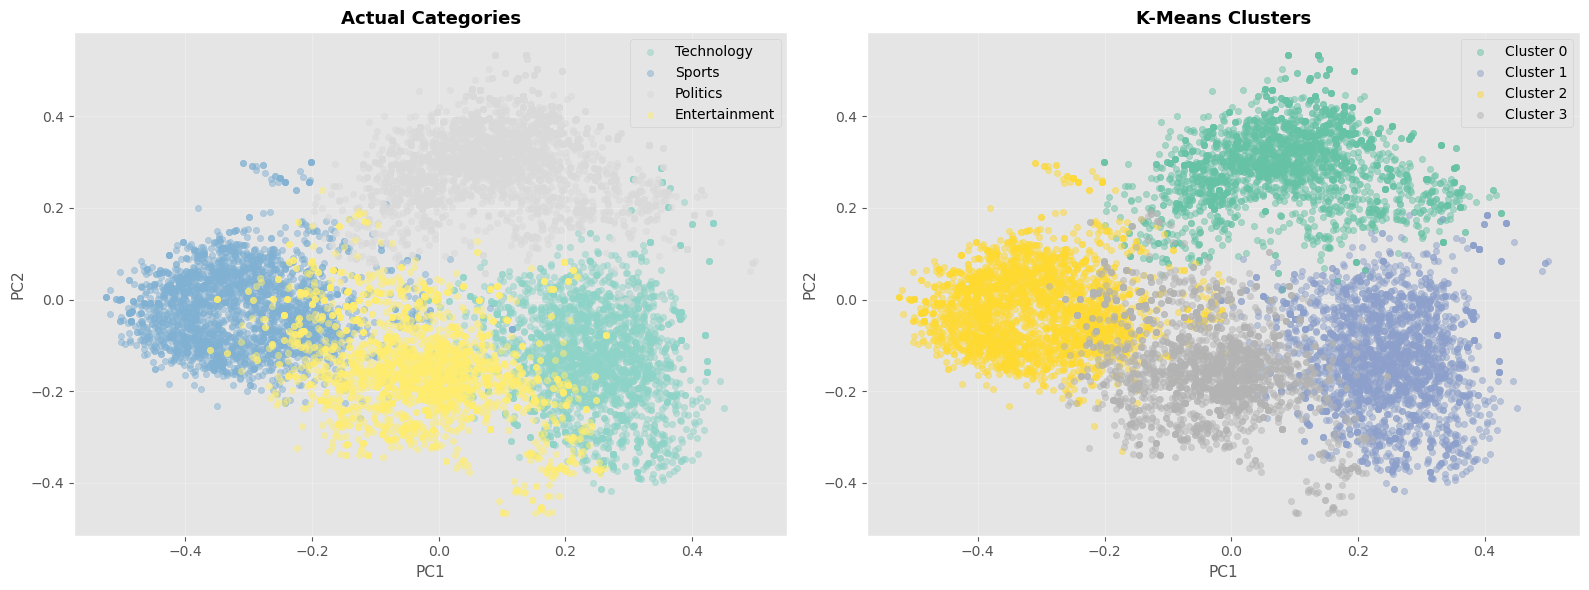

Plot saved to: visualizations/clustering_comparison.png


In [10]:
# Visualize clusters on PCA plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Colored by actual category
for i, category in enumerate(categories):
    mask = df['category'] == category
    axes[0].scatter(embeddings_2d_pca[mask, 0], 
                   embeddings_2d_pca[mask, 1],
                   c=[colors[i]], 
                   label=category,
                   alpha=0.5,
                   s=20)

axes[0].set_xlabel('PC1', fontsize=11)
axes[0].set_ylabel('PC2', fontsize=11)
axes[0].set_title('Actual Categories', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Right: Colored by cluster
cluster_colors = plt.cm.Set2(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    mask = df['cluster'] == i
    axes[1].scatter(embeddings_2d_pca[mask, 0], 
                   embeddings_2d_pca[mask, 1],
                   c=[cluster_colors[i]], 
                   label=f'Cluster {i}',
                   alpha=0.5,
                   s=20)

axes[1].set_xlabel('PC1', fontsize=11)
axes[1].set_ylabel('PC2', fontsize=11)
axes[1].set_title('K-Means Clusters', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('visualizations/clustering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved to: visualizations/clustering_comparison.png")

## 10. Within-Category vs Between-Category Similarity

Analyzing category similarities...

Average Within-Category Similarities:
  Technology     : 0.1710 +/- 0.1203
  Sports         : 0.2056 +/- 0.1406
  Politics       : 0.1423 +/- 0.1281
  Entertainment  : 0.1644 +/- 0.1262

Average Between-Category Similarity: 0.0297
  (std: 0.0745)


C:\Users\OsterriederJRO\AppData\Local\Temp\ipykernel_7936\1662216767.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)


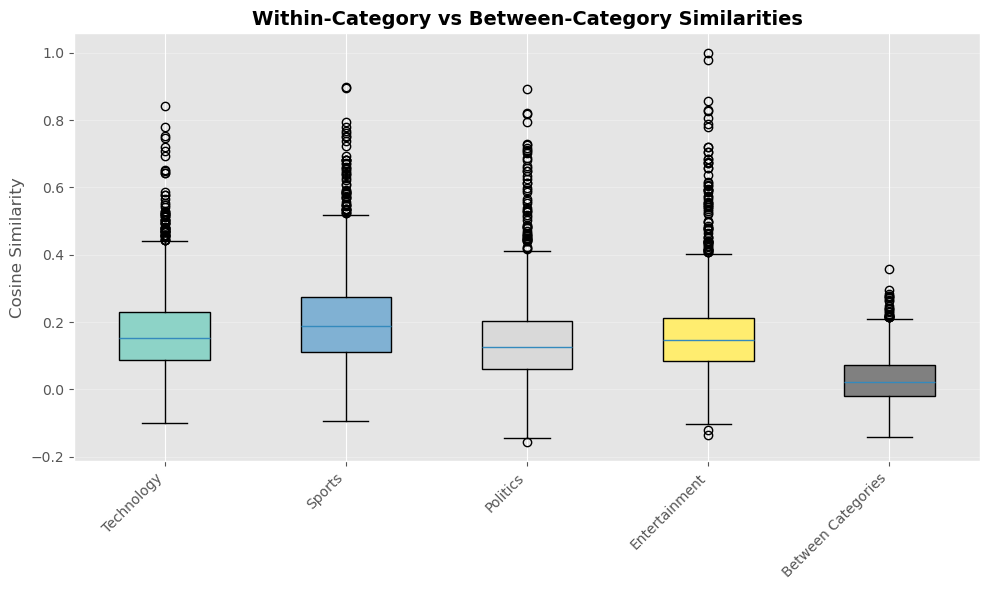


Plot saved to: visualizations/similarity_distribution.png


In [11]:
print("Analyzing category similarities...")

category_similarities = {}
between_category_sims = []

for cat in df['category'].unique():
    cat_indices = df[df['category'] == cat].index[:100].tolist()
    
    within_sims = []
    for i in range(len(cat_indices)):
        for j in range(i+1, min(i+20, len(cat_indices))):
            sim = cosine_similarity(embeddings[cat_indices[i]], 
                                  embeddings[cat_indices[j]])
            within_sims.append(sim)
    
    category_similarities[cat] = within_sims
    
    # Between-category
    other_cats = df[df['category'] != cat].index[:50].tolist()
    for i in cat_indices[:30]:
        for j in other_cats[:10]:
            sim = cosine_similarity(embeddings[i], embeddings[j])
            between_category_sims.append(sim)

print("\nAverage Within-Category Similarities:")
for cat, sims in category_similarities.items():
    print(f"  {cat:15s}: {np.mean(sims):.4f} +/- {np.std(sims):.4f}")

print(f"\nAverage Between-Category Similarity: {np.mean(between_category_sims):.4f}")
print(f"  (std: {np.std(between_category_sims):.4f})")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

data_to_plot = [sims for sims in category_similarities.values()]
data_to_plot.append(between_category_sims)

labels = list(category_similarities.keys()) + ['Between Categories']

bp = ax.boxplot(data_to_plot, labels=labels, patch_artist=True)

for i, box in enumerate(bp['boxes']):
    if i < len(categories):
        box.set_facecolor(colors[i])
    else:
        box.set_facecolor('gray')

ax.set_ylabel('Cosine Similarity', fontsize=12)
ax.set_title('Within-Category vs Between-Category Similarities', 
            fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('visualizations/similarity_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: visualizations/similarity_distribution.png")

## 11. Summary and Key Takeaways

### What We Learned:

1. **Embeddings are powerful**: They capture semantic meaning in numbers
2. **Cosine similarity works**: Headlines with similar meanings have high similarity scores
3. **Dimensionality reduction helps**: PCA and t-SNE make high-dimensional data visible
4. **Categories cluster**: Similar topics group together in embedding space
5. **Within-category similarity**: Headlines in the same category are more similar than across categories

### Practical Applications:

- **Semantic Search**: Find relevant documents by meaning, not just keywords
- **Clustering**: Automatically group similar texts
- **Classification**: Train classifiers on embeddings
- **Recommendation**: Find similar items
- **Duplicate Detection**: Find near-duplicate content

### Next Steps:

1. Try different models (BERT, RoBERTa, GPT)
2. Fine-tune embeddings on domain-specific data
3. Build a semantic search engine
4. Train classifiers using embeddings as features
5. Explore cross-lingual embeddings

## 12. Further Exploration (Optional)

Try these exercises:

1. Find the centroid (average embedding) of each category
2. Measure distance of each headline to its category centroid
3. Find outliers (headlines far from their category centroid)
4. Build a simple classifier using nearest centroid
5. Visualize how embeddings change for similar headlines with different words